In [1]:
import errno
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as pl
import sys
import pandas as pd
import os
import urllib
from scipy.stats import linregress
from tqdm import tqdm

In [2]:
pl.rcParams['figure.figsize'] = (16/2.54, 16/2.54)
pl.rcParams['font.size'] = 11
pl.rcParams['font.family'] = 'Arial'
pl.rcParams['xtick.direction'] = 'out'
pl.rcParams['xtick.minor.visible'] = True
pl.rcParams['ytick.minor.visible'] = True
pl.rcParams['ytick.right'] = True
pl.rcParams['xtick.top'] = True
pl.rcParams['figure.dpi'] = 96

In [3]:
class _DownloadProgressBar(tqdm):
    def update_to(self, blocks=1, blocksize=1, totalsize=None):
        """Update download progress bar.
        Parameters
        ----------
            blocks : int, optional
                Number of blocks transferred so far [default: 1].
            blocksize : int, optional
                Size of each block (in tqdm units) [default: 1].
            totalsize : int, optional
                Total size (in tqdm units). If [default: None] remains unchanged.
        """
        if totalsize is not None:
            self.total = totalsize
        self.update(blocks * blocksize - self.n)


def check_and_download(url, filepath, clobber=False):
    """Check prescence of a file and downloads if not present.
    Parameters
    ----------
        url : str
            url to download from
        filepath : str
            filename to download to
        clobber : bool, default=False
            False if download should not overwrite existing file, True if it should
    """
    if clobber or not os.path.isfile(filepath):
        with _DownloadProgressBar(
            unit="B", unit_scale=True, miniters=1, desc=url.split("/")[-1]
        ) as progress:
            urllib.request.urlretrieve(
                url, filename=filepath, reporthook=progress.update_to
            )

def mkdir_p(path):
    """Check to see if directory exists, and if not, create it.
    Parameters
    ----------
        path : str
            directory to create
    Raises
    ------
        OSError:
            if directory cannot be created
    """
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

In [4]:
mkdir_p('../data_input/input4mips/')
check_and_download(
    'http://aims3.llnl.gov/thredds/fileServer/user_pub_work/input4MIPs/CMIP6/CMIP/SOLARIS-HEPPA/SOLARIS-HEPPA-3-2/atmos/mon/multiple/gm/v20170103/solarforcing-ref-mon_input4MIPs_solar_CMIP_SOLARIS-HEPPA-3-2_gn_185001-229912.nc',
    '../data_input/input4mips/solarforcing-ref-mon_input4MIPs_solar_CMIP_SOLARIS-HEPPA-3-2_gn_185001-229912.nc',
#    clobber=True
)

In [5]:
nc_future = Dataset('../data_input/input4mips/solarforcing-ref-mon_input4MIPs_solar_CMIP_SOLARIS-HEPPA-3-2_gn_185001-229912.nc')
tsi_future = nc_future.variables['tsi'][:(251*12)]
nc_future.close()

In [6]:
years = np.arange(1850, 2101, dtype=int)
isleap = np.zeros(251)
isleap[np.logical_and(years%4==0, np.logical_or(years%100!=0, years%400==0))] = 1

In [7]:
tsi = np.zeros(251)
for i, year in enumerate(years):
    weights = [31,28+isleap[i],31,30,31,30,31,31,30,31,30,31]
    tsi[i] = np.average(tsi_future[(i)*12:(1+i)*12], weights=weights)

In [8]:
tsi_baseline = np.mean(tsi[:24])
tsi_baseline

1360.7481368624874

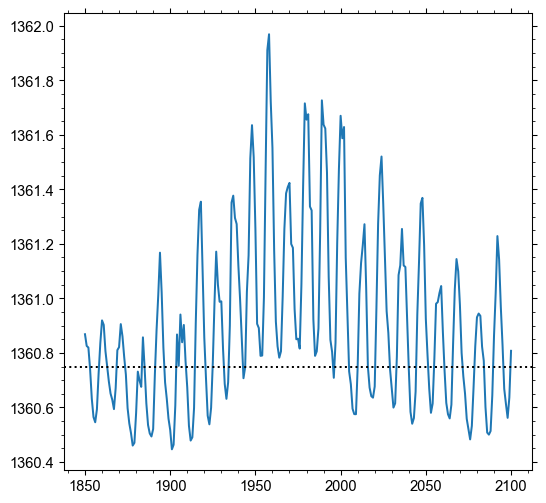

In [9]:
pl.plot(np.arange(1850, 2101), tsi)
pl.axhline(tsi_baseline, ls=':', color='k')

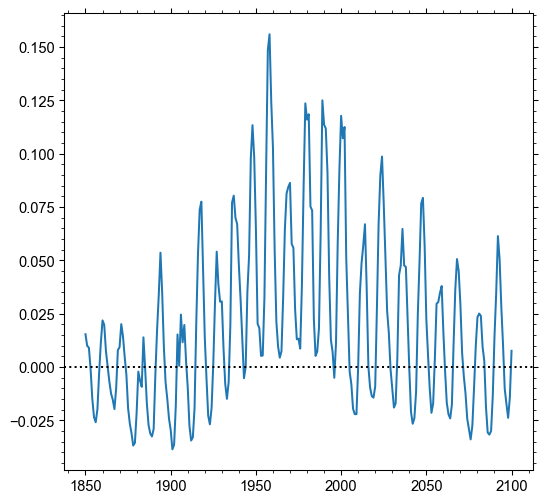

In [10]:
solar_erf = 0.25 * (tsi-tsi_baseline) * 0.71 * 0.72  # include RA
pl.plot(np.arange(1850, 2101), solar_erf)
pl.axhline(0, ls=':', color='k')

In [11]:
# pre-processed RFMIP-histnat runs. Method pretty similar to notebook that does the ERF for aerosols
rfmip_tier2 = pd.read_csv('../data_input/RFMIP-ERF-tier2.csv', index_col=0)
natural = rfmip_tier2[['CanESM5 NAT', 'CNRM-CM6-1 NAT', 'GFDL-CM4 NAT', 'GISS-E2-1-G NAT', 'HadGEM3-GC31-LL NAT', 'IPSL-CM6A-LR NAT', 'MIROC6 NAT', 'NorESM2-LM NAT']]
natural

,CanESM5 NAT,CNRM-CM6-1 NAT,GFDL-CM4 NAT,GISS-E2-1-G NAT,HadGEM3-GC31-LL NAT,IPSL-CM6A-LR NAT,MIROC6 NAT,NorESM2-LM NAT
year,,,,,,,,
1850,0.437284,-0.293584,0.127826,0.109629,0.217894,0.193991,-0.037077,0.351767
1851,0.003158,-0.229548,0.223375,-0.329789,0.280323,0.193944,0.231050,0.195244
1852,-0.202280,-0.012110,0.199512,0.149565,0.137737,-0.098239,0.075457,-0.077189
1853,-0.161843,-0.170152,0.166399,-0.105968,0.189263,0.219294,-0.145791,0.339919
1854,0.061468,-0.003006,0.364801,0.011749,0.158687,0.168342,0.149833,-0.216705
...,...,...,...,...,...,...,...,...
2096,0.154930,NaN,-0.133315,0.181825,0.103691,0.169500,0.163041,NaN
2097,0.008238,NaN,-0.067166,-0.009377,0.154095,0.008598,0.014279,NaN
2098,-0.016735,NaN,-0.162721,0.127037,0.031064,0.134732,-0.153561,NaN


In [12]:
natural.loc[1850:2015].mean().mean()

0.04314899812333576

In [13]:
np.mean(solar_erf[:165])

0.02506019433529901

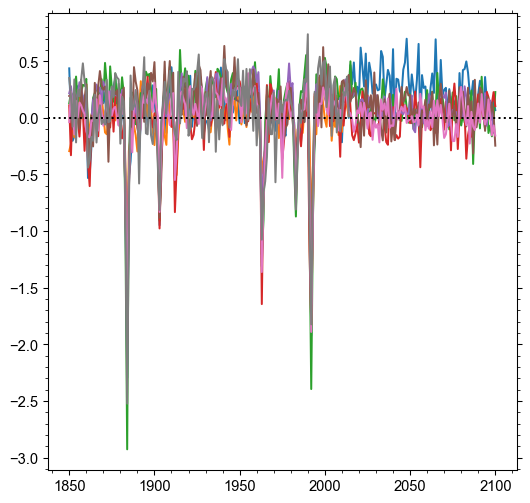

In [14]:
pl.plot(natural)
pl.axhline(0, ls=':', color='k')

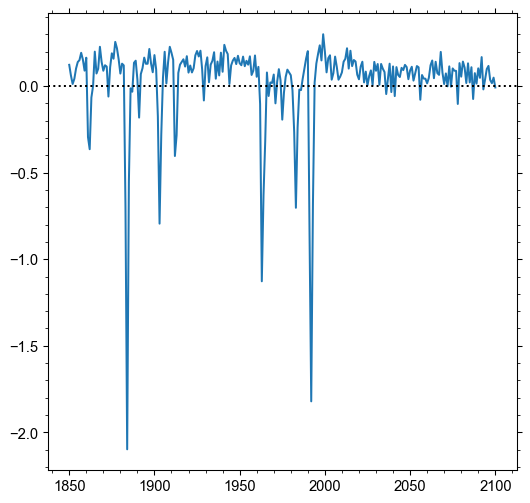

In [15]:
pl.plot(natural.mean(axis=1) - solar_erf)
pl.axhline(0, ls=':', color='k')

In [16]:
volc = natural - solar_erf[:,None]
volc

,CanESM5 NAT,CNRM-CM6-1 NAT,GFDL-CM4 NAT,GISS-E2-1-G NAT,HadGEM3-GC31-LL NAT,IPSL-CM6A-LR NAT,MIROC6 NAT,NorESM2-LM NAT
year,,,,,,,,
1850,0.421896,-0.308972,0.112438,0.094241,0.202506,0.178603,-0.052465,0.336379
1851,-0.006758,-0.239463,0.213459,-0.339705,0.270407,0.184028,0.221134,0.185328
1852,-0.211416,-0.021246,0.190376,0.140429,0.128601,-0.107375,0.066321,-0.086325
1853,-0.160867,-0.169176,0.167374,-0.104993,0.190238,0.220270,-0.144815,0.340895
1854,0.076319,0.011845,0.379652,0.026600,0.173538,0.183193,0.164684,-0.201854
...,...,...,...,...,...,...,...,...
2096,0.165108,NaN,-0.123136,0.192004,0.113870,0.179679,0.173219,NaN
2097,0.025471,NaN,-0.049933,0.007856,0.171329,0.025831,0.031512,NaN
2098,0.007055,NaN,-0.138932,0.150827,0.054854,0.158522,-0.129772,NaN


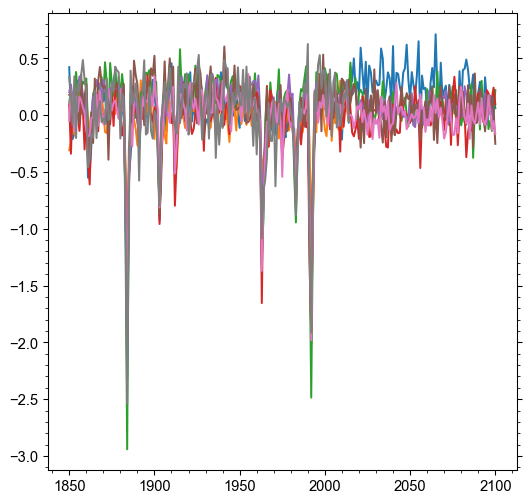

In [17]:
pl.plot(volc)

In [18]:
volc.loc[1992,:]

CanESM5 NAT           -2.012769
CNRM-CM6-1 NAT        -1.013556
GFDL-CM4 NAT          -2.486031
GISS-E2-1-G NAT       -1.918139
HadGEM3-GC31-LL NAT   -1.737457
IPSL-CM6A-LR NAT      -1.503888
MIROC6 NAT            -1.981592
NorESM2-LM NAT        -1.914555
Name: 1992, dtype: float64

In [19]:
# This dataset is processed from the Toohey and Sigl / CMIP6 / GloSSAC data - see supplement for info
# full crunching notebook will be released with AR6 :)
saod = pd.read_csv("../data_input/volcanic_sAOD_monthly_-50001-201912.csv", index_col=0)

In [20]:
saod_annual = np.zeros(165)
for year in range(1850,2015):
    saod_annual[year-1850] = saod.loc[year:year+1,:].mean()
saod_annual = pd.DataFrame(
    {
        'year' : np.arange(1850,2015,dtype=int),
        'sAOD' : saod_annual
    }
)
saod_annual.set_index('year',inplace=True)
saod_annual

,sAOD
year,
1850,0.003189
1851,0.002991
1852,0.003256
1853,0.012348
1854,0.014015
...,...
2010,0.006070
2011,0.008002
2012,0.006223


In [21]:
saod_annual.mean()

sAOD    0.010341
dtype: float64

In [22]:
volc_saod = volc.join(saod_annual-saod_annual.mean())

In [23]:
volc_saod

,CanESM5 NAT,CNRM-CM6-1 NAT,GFDL-CM4 NAT,GISS-E2-1-G NAT,HadGEM3-GC31-LL NAT,IPSL-CM6A-LR NAT,MIROC6 NAT,NorESM2-LM NAT,sAOD
year,,,,,,,,,
1850,0.421896,-0.308972,0.112438,0.094241,0.202506,0.178603,-0.052465,0.336379,-0.007152
1851,-0.006758,-0.239463,0.213459,-0.339705,0.270407,0.184028,0.221134,0.185328,-0.007350
1852,-0.211416,-0.021246,0.190376,0.140429,0.128601,-0.107375,0.066321,-0.086325,-0.007085
1853,-0.160867,-0.169176,0.167374,-0.104993,0.190238,0.220270,-0.144815,0.340895,0.002007
1854,0.076319,0.011845,0.379652,0.026600,0.173538,0.183193,0.164684,-0.201854,0.003673
...,...,...,...,...,...,...,...,...,...
2096,0.165108,NaN,-0.123136,0.192004,0.113870,0.179679,0.173219,NaN,NaN
2097,0.025471,NaN,-0.049933,0.007856,0.171329,0.025831,0.031512,NaN,NaN
2098,0.007055,NaN,-0.138932,0.150827,0.054854,0.158522,-0.129772,NaN,NaN


In [24]:
sl, ic, _,_,_ = linregress(volc_saod.loc[:2014,'sAOD'].values, volc_saod.loc[:2014,'CanESM5 NAT'].values)

In [25]:
sl

-20.629760341041788

-20.629760341041788

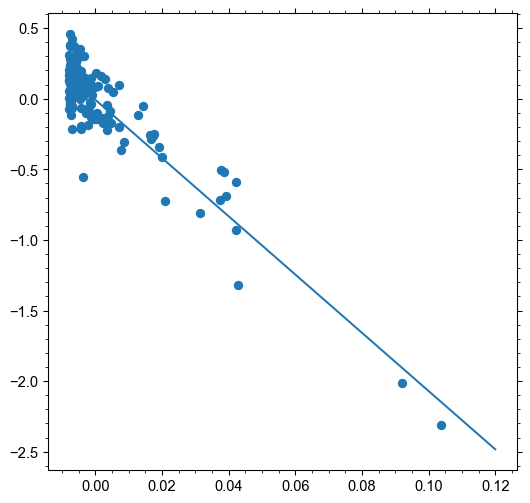

In [26]:
pl.scatter(volc_saod.loc[:2014,'sAOD'].values, volc_saod.loc[:2014,'CanESM5 NAT'].values)
sl, ic, _,_,_ = linregress(volc_saod.loc[:2014,'sAOD'].values, volc_saod.loc[:2014,'CanESM5 NAT'].values)
pl.plot(np.linspace(0,0.12,100), sl*np.linspace(0,0.12,100)+ic)
sl

-26.459955546874045

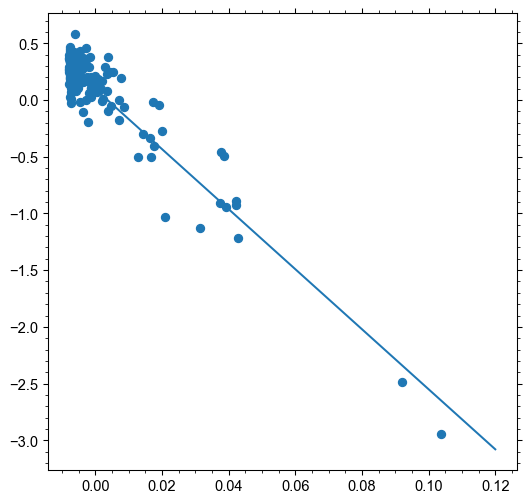

In [27]:
pl.scatter(volc_saod.loc[:2014,'sAOD'].values, volc_saod.loc[:2014,'GFDL-CM4 NAT'].values)
sl, ic, _,_,_ = linregress(volc_saod.loc[:2014,'sAOD'].values, volc_saod.loc[:2014,'GFDL-CM4 NAT'].values)
pl.plot(np.linspace(0,0.12,100), sl*np.linspace(0,0.12,100)+ic)
sl

-19.42244361593596

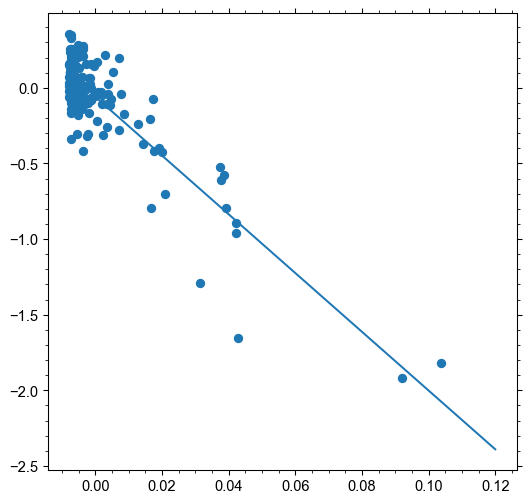

In [28]:
pl.scatter(volc_saod.loc[:2014,'sAOD'].values, volc_saod.loc[:2014,'GISS-E2-1-G NAT'].values)
sl, ic, _,_,_ = linregress(volc_saod.loc[:2014,'sAOD'].values, volc_saod.loc[:2014,'GISS-E2-1-G NAT'].values)
pl.plot(np.linspace(0,0.12,100), sl*np.linspace(0,0.12,100)+ic)
sl

-19.72218852170384

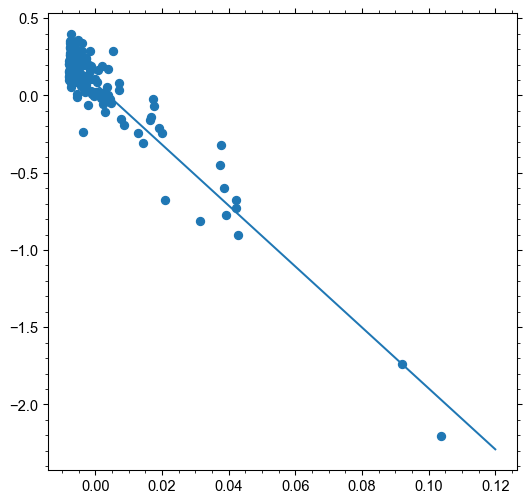

In [29]:
pl.scatter(volc_saod.loc[:2014,'sAOD'].values, volc_saod.loc[:2014,'HadGEM3-GC31-LL NAT'].values)
sl, ic, _,_,_ = linregress(volc_saod.loc[:2014,'sAOD'].values, volc_saod.loc[:2014,'HadGEM3-GC31-LL NAT'].values)
pl.plot(np.linspace(0,0.12,100), sl*np.linspace(0,0.12,100)+ic)
sl

-19.72218852170384

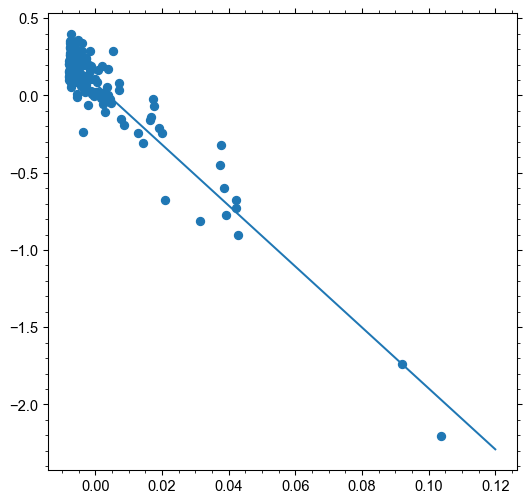

In [30]:
pl.scatter(volc_saod.loc[:2014,'sAOD'].values, volc_saod.loc[:2014,'HadGEM3-GC31-LL NAT'].values)
sl, ic, _,_,_ = linregress(volc_saod.loc[:2014,'sAOD'].values, volc_saod.loc[:2014,'HadGEM3-GC31-LL NAT'].values)
pl.plot(np.linspace(0,0.12,100), sl*np.linspace(0,0.12,100)+ic)
sl

-18.49659638764654

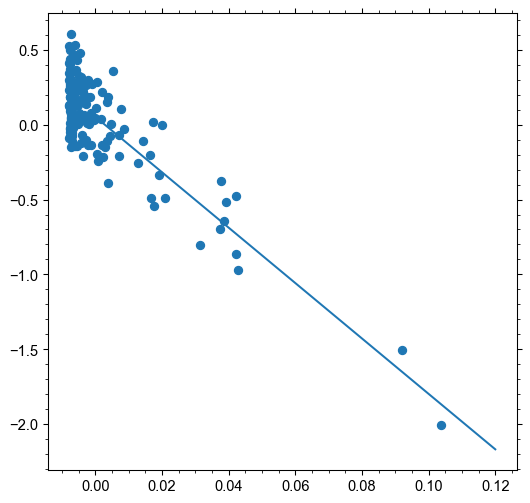

In [31]:
pl.scatter(volc_saod.loc[:2014,'sAOD'].values, volc_saod.loc[:2014,'IPSL-CM6A-LR NAT'].values)
sl, ic, _,_,_ = linregress(volc_saod.loc[:2014,'sAOD'].values, volc_saod.loc[:2014,'IPSL-CM6A-LR NAT'].values)
pl.plot(np.linspace(0,0.12,100), sl*np.linspace(0,0.12,100)+ic)
sl

-18.242672872895756

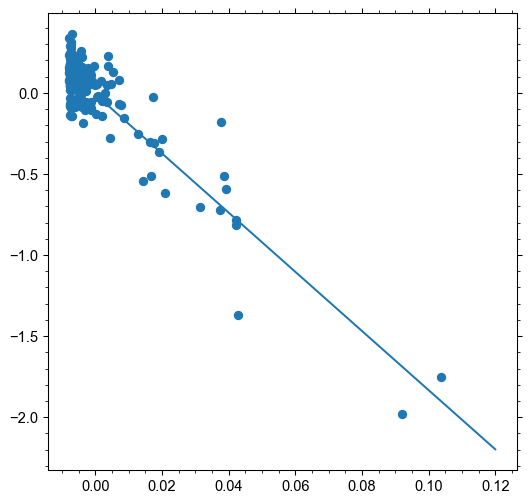

In [32]:
pl.scatter(volc_saod.loc[:2014,'sAOD'].values, volc_saod.loc[:2014,'MIROC6 NAT'].values)
sl, ic, _,_,_ = linregress(volc_saod.loc[:2014,'sAOD'].values, volc_saod.loc[:2014,'MIROC6 NAT'].values)
pl.plot(np.linspace(0,0.12,100), sl*np.linspace(0,0.12,100)+ic)
sl

-20.976038030665883

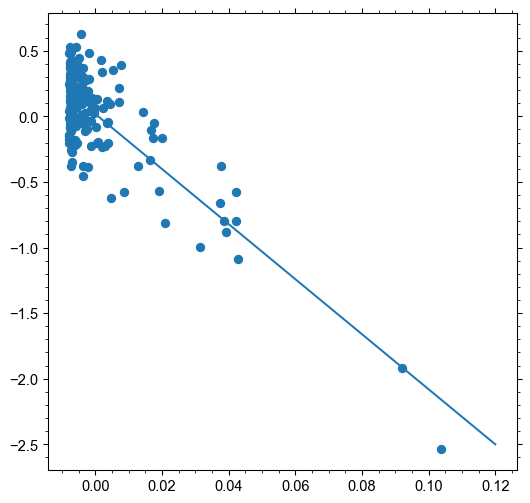

In [33]:
pl.scatter(volc_saod.loc[:2014,'sAOD'].values, volc_saod.loc[:2014,'NorESM2-LM NAT'].values)
sl, ic, _,_,_ = linregress(volc_saod.loc[:2014,'sAOD'].values, volc_saod.loc[:2014,'NorESM2-LM NAT'].values)
pl.plot(np.linspace(0,0.12,100), sl*np.linspace(0,0.12,100)+ic)
sl

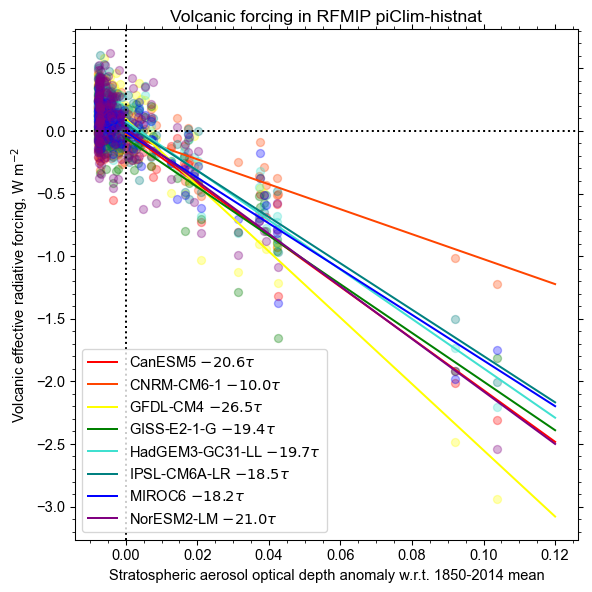

In [34]:
#pl.rcParams['font.size']=16
#fig, ax=pl.subplots(figsize=(9, 9))
fig, ax=pl.subplots(figsize=(16/2.54, 16/2.54))
slope = np.zeros(7)
colors = {
    'CanESM5'        : 'red',#'#1e4c24',
    'CNRM-CM6-1'     : 'orangered',
    'E3SM'           : 'darkorange',
    'GFDL-ESM4'      : 'yellowgreen', 
    'GFDL-CM4'       : 'yellow',#'green',
    'GISS-E2-1-G'    : 'green',#'#771d7b',
    'HadGEM3-GC31-LL': 'turquoise',
    'IPSL-CM6A-LR'   : 'teal',
    'MIROC6'         : 'blue',#b85fb7',
    'MRI-ESM2-0'     : 'blueviolet',
    'NorESM2-LM'     : 'purple',#'red',
    'UKESM1-0-LL'    : 'crimson',
}
slope = {}
for model in ['CanESM5', 'CNRM-CM6-1', 'GFDL-CM4', 'GISS-E2-1-G', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'NorESM2-LM']:
    ax.scatter(volc_saod.loc[:2014,'sAOD'].values, volc_saod.loc[:2014,'%s NAT' % model].values, color=colors[model], alpha=0.3)
    slope[model], ic, _,_,_ = linregress(volc_saod.loc[:2014,'sAOD'].values, volc_saod.loc[:2014,'%s NAT' % model].values)
    ax.plot(np.linspace(0,0.12,100), slope[model]*np.linspace(0,0.12,100)+ic, color=colors[model], label=r'%s $%4.1f \tau$' % (model, slope[model]))
ax.legend()
ax.set_ylabel('Volcanic effective radiative forcing, W m$^{-2}$')
ax.set_xlabel('Stratospheric aerosol optical depth anomaly w.r.t. 1850-2014 mean')
ax.set_title('Volcanic forcing in RFMIP piClim-histnat')
ax.axhline(0, color='k', ls=':')
ax.axvline(0, color='k', ls=':')
pl.tight_layout()
pl.savefig('../figures/figureS8.png', dpi=300)
pl.savefig('../figures/figureS8.pdf')

In [35]:
slope

{'CanESM5': -20.629760341041788,
 'CNRM-CM6-1': -9.96433975207714,
 'GFDL-CM4': -26.459955546874045,
 'GISS-E2-1-G': -19.42244361593596,
 'HadGEM3-GC31-LL': -19.72218852170384,
 'IPSL-CM6A-LR': -18.49659638764654,
 'MIROC6': -18.242672872895756,
 'NorESM2-LM': -20.976038030665883}

In [36]:
dummy = np.zeros(8)
for i, value in enumerate(slope.values()):
    dummy[i]=value
    
dummy.mean()

-19.23924938360512